# Phân vùng trên thẻ sinh viên

In [1]:
import matplotlib.pyplot as plt
import matplotlib.image as img
import numpy as np
import cv2
import math

In [2]:
#Hàm dùng để show ảnh
def imshow(bgr_img):
    img = cv2.cvtColor(bgr_img, cv2.COLOR_BGR2RGB)
    plt.imshow(img)
    plt.show()

# Đọc dữ liệu

(229, 360, 3)


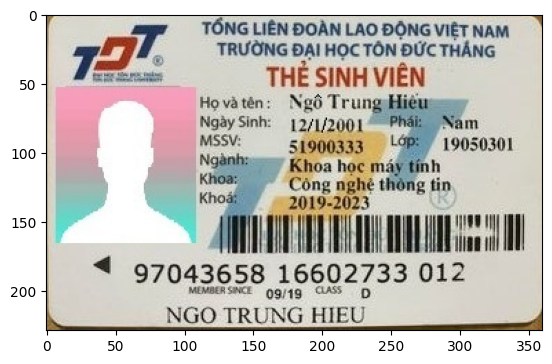

In [3]:
filename = 'image/' + 'theSV' + '.jpg'
card = cv2.imread(filename)
print(card.shape)
imshow(card)

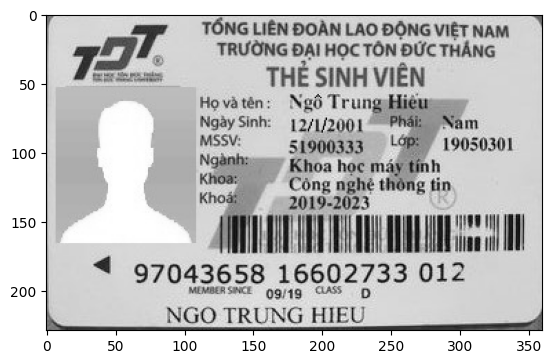

In [4]:
# chuyển sang ảnh xám
gray = cv2.cvtColor(card, cv2.COLOR_BGR2GRAY)
imshow(gray)

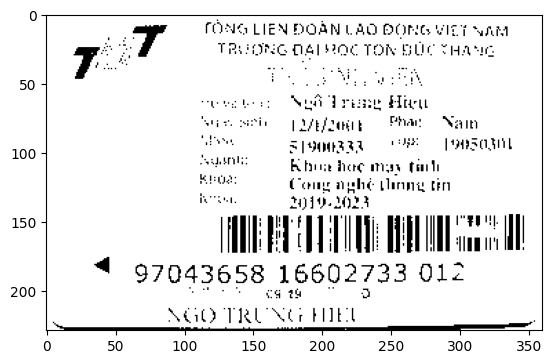

In [5]:
# sau đó chuyển sang ảnh nhị phân
th, binary_img = cv2.threshold(gray, 70, 255, cv2.THRESH_BINARY)
imshow(binary_img)

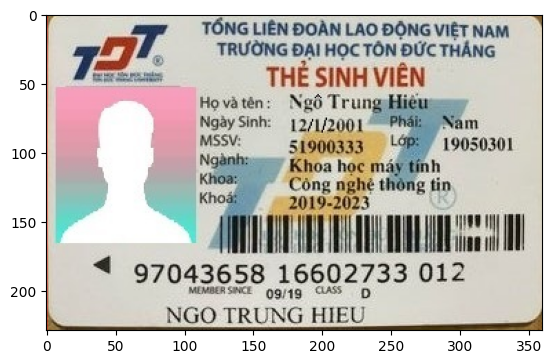

In [6]:
# trả về foreground của đối tượng 
cnts, h = cv2.findContours(binary_img, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
point = []
rgb = card.copy()
for i in cnts:
  # tọa độ của ảnh
  (x,y,w,h) = cv2.boundingRect(i)
  
  # lấy ngưỡng 
  minArea = cv2.minAreaRect(i) 
  box = minArea[1][0]*minArea[1][1]

  # tạo ngưỡng giá trị
  if box > 50000 and box < 1000000: 
    cv2.rectangle(rgb, (x,y), (x+w, y+h), (0,0,255))
    point.append([(x,y), (x+w, y+h)])
    
imshow(rgb)

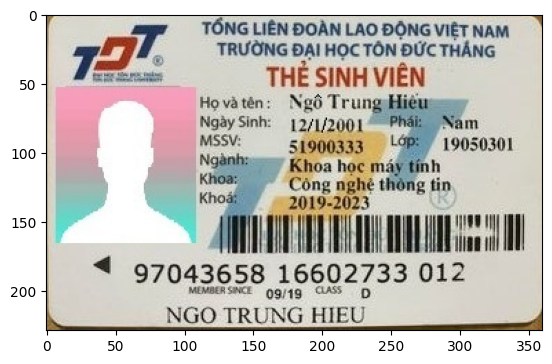

In [7]:
(x,y),(xw,yh) = point[0]
# cắt ảnh
cropped_card = card[y:yh, x:xw]
imshow(cropped_card)

# Tiền xử lý ảnh

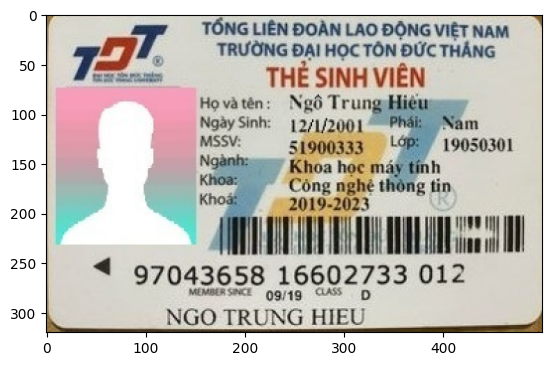

In [8]:
# đưa về shape chuẩn của thẻ sinh viên
preprocess_card = cv2.resize(cropped_card, (500, 320), interpolation = cv2.INTER_AREA)
imshow(preprocess_card)

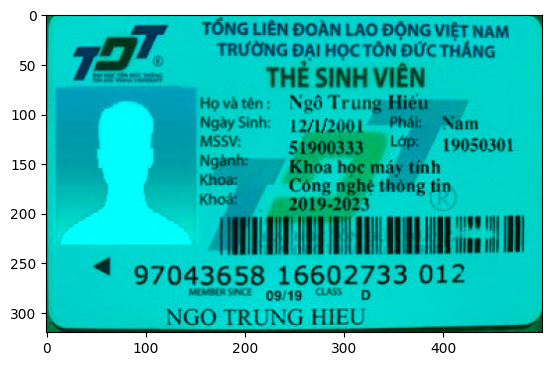

In [9]:
img = preprocess_card.copy()
img[:,:,2] = 0
imshow(img)

# Xác định vị trí các box chứa thông tin trên thẻ

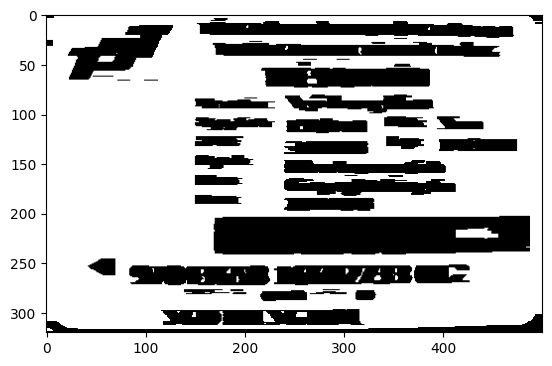

In [10]:
# chuyển sang xám
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
# sau đó chuyển sang trắng đen (ảnh nhị phân)
th, binary_img = cv2.threshold(gray, 70, 255, cv2.THRESH_BINARY)

s = np.array([[0,0,0], # lấy mặt nạ giãn ngang
              [1,1,1],
              [0,0,0]], dtype = np.uint8) 
iters = 6 # giản nở để lấy thông tin theo chiều ngang 6 lần
Ie_binary_img = cv2.erode(binary_img, s, iterations=iters) 
imshow(Ie_binary_img)

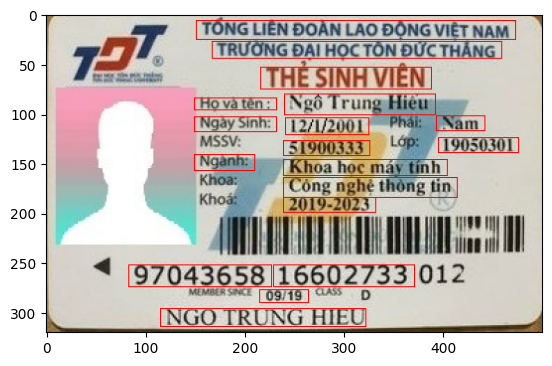

In [11]:
# trả về fore ground của đối tượng  của đối tượng
cnts, h = cv2.findContours(Ie_binary_img, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
location = []

rgb = preprocess_card.copy()

for i in cnts:
  (x,y,w,h) = cv2.boundingRect(i) # tọa độ của chữ
  minArea = cv2.minAreaRect(i) # lấy ngưỡng
  box = minArea[1][0]*minArea[1][1]
  if box > 550 and box < 7000 and w > 3*h: # tạo ngưỡng giá trị
    cv2.rectangle(rgb, (x,y), (x+w, y+h), (0,0,255))
    location.append([(x,y), (x+w, y+h)]) # thêm vị trí của ảnh vào location
    
imshow(rgb)

In [12]:
# Hàm sắp xếp vị trí theo tọa độ theo thứ tự từ trên xuống dưới dựa vào tọa độ
def sort_by_location(loc):
    for i in range(len(loc)):
        for j in range(i+1, len(loc)):
            if loc[i][0][1] > loc[j][0][1]:
                loc[i], loc[j] = loc[j], loc[i]
    return loc

sorted_loc = sort_by_location(location)

# cắt các ảnh nhỏ ra theo tọa độ đã sắp xếp
sub_images = []
for loc in sorted_loc:
    (x,y),(xw,yh) = loc
    sub_images.append(preprocess_card[y:yh, x:xw])
len(sub_images)

18

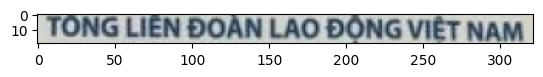

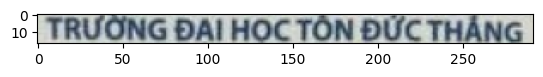

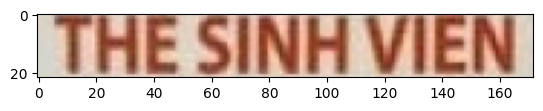

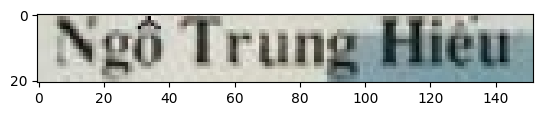

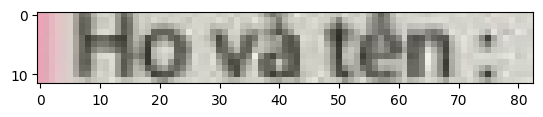

In [13]:
# hiển thị 5 ảnh đã được cắt ra
for img in sub_images[:5]:
    imshow(img)

# Xây dựng model để trích xuất thông tin trong ảnh
Sử dụng model OCR trên github vietocr

In [14]:
from PIL import Image
from vietocr.tool.predictor import Predictor
from vietocr.tool.config import Cfg

In [15]:
# config để sử dụng model
config = Cfg.load_config_from_name('vgg_transformer')

# config['weights'] = './weights/transformerocr.pth'
config['weights'] = 'https://drive.google.com/uc?id=13327Y1tz1ohsm5YZMyXVMPIOjoOA0OaA'
config['cnn']['pretrained']=False
config['device'] = 'cpu'
config['predictor']['beamsearch']=False

In [16]:
# khởi tạo đối tượng Predictor để dịch chữ từ ảnh
detector = Predictor(config)

C:\Users\DELL\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\DELL\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


File exists: C:\Users\DELL\.cache/gdown\https-COLON--SLASH--SLASH-drive.google.com-SLASH-uc-QUESTION-id-EQUAL-13327Y1tz1ohsm5YZMyXVMPIOjoOA0OaA


# Hiện thực

TỔNG LIÊN ĐOÀN LAO ĐỘNG VIỆT NAM


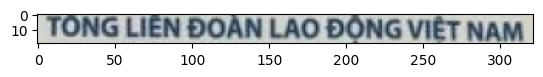

TRƯỜNG ĐẠI HỌC TÔN ĐỨC THẢNG


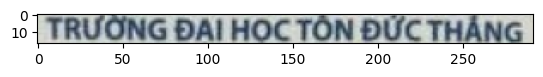

THE SINH VIEN


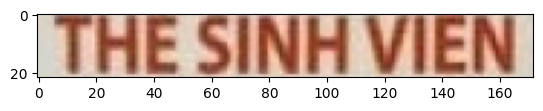

Ngô Trung Hiếu


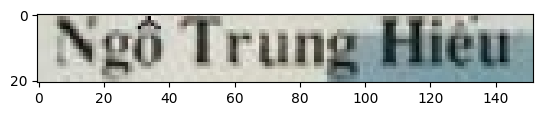

Ho và ten:


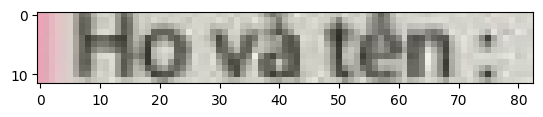

Nam


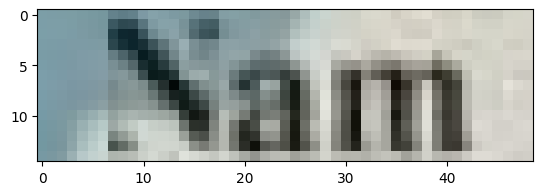

Ngày Sinh:


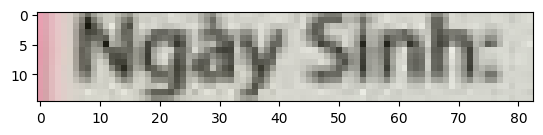

12/1/2001


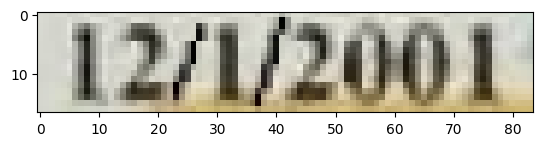

19050301


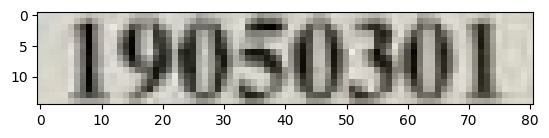

51900333


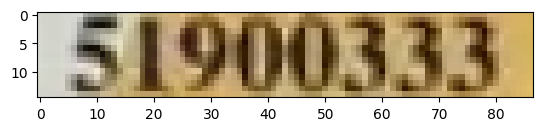

Nganh:


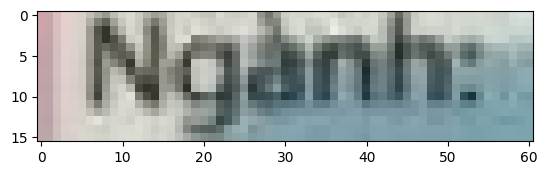

Khoa học máy tính


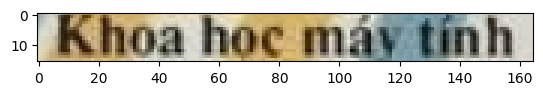

Công nghẻ thòng tin


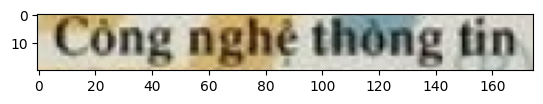

2019-2023


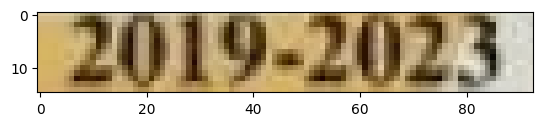

16602733


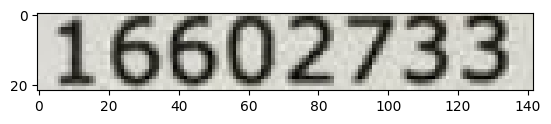

97043658


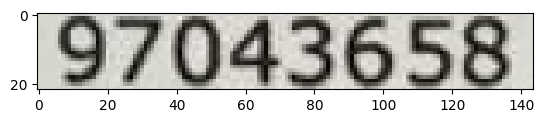

09/19


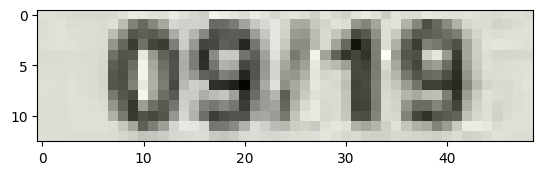

VÀ NGÔ TRUNG HIẾU


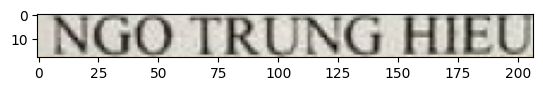

In [17]:
# tiến hành đưa các ảnh có chứa thông tin text cần thiết vào để model dự đoán
info = []

for s_img in sub_images:
    img = Image.fromarray(s_img) # chuyển array 3d thành đối tượng ảnh trước khi đưa vào dự đoán
    s = detector.predict(img) # đưa ảnh trên vào để dự đoán, s là kết quả text mà hàm trả về
    info.append(s)
    print(s) # text
    imshow(s_img) # image with text

In [18]:
# thông tin cuối cùng (thông tin cần thiết) đã được trích xuất từ cccd mà chúng ta đưa vào
info

['TỔNG LIÊN ĐOÀN LAO ĐỘNG VIỆT NAM',
 'TRƯỜNG ĐẠI HỌC TÔN ĐỨC THẢNG',
 'THE SINH VIEN',
 'Ngô Trung Hiếu',
 'Ho và ten:',
 'Nam',
 'Ngày Sinh:',
 '12/1/2001',
 '19050301',
 '51900333',
 'Nganh:',
 'Khoa học máy tính',
 'Công nghẻ thòng tin',
 '2019-2023',
 '16602733',
 '97043658',
 '09/19',
 'VÀ NGÔ TRUNG HIẾU']

# Một số thông tin cần thiết:
+ tên trường
+ họ và tên
+ ngày sinh
+ giới tính
+ mã lớp
+ mã số sinh viên
+ ngành

ta có thể sử dụng regex để lọc một vài thông tin cần thiết từ những thông tin trên

In [19]:
import re

important_info = {}
# danh sách họ
first_name_list = [ r'Ngô', r'Nguyễn', r'Huỳnh', r'Lê', r'Đặng', r'Phạm']
# năm sinh
year_pattern = r'[0-9]{2}[/\:][0-9]{1}[/\:][0-9]{4}' 
# giới tính
gender_pattern = r'Nam|Nữ|Nu|nu|Nư|Nũ' 
# MSSV
mssv_pattern = r'[5]{1}[0-9]{7}'
# lớp
classes_pattern = r'[19]{2}[0-9]{6}'
# trường
shcool_pattern = r'TRƯỜNG+ [\w\d\s]+'
# chuyên ngành
major_pattern = r'Khoa+ [\w\d\s]+'


In [20]:
for in4 in info:
    name = ''
    for first_name in first_name_list:
        name_pattern = r'^'+first_name+r'[\w\s]+'
        name = re.findall(name_pattern, in4)
        if name != []:
            break

    birth = re.findall(year_pattern, in4)
    gender = re.findall(gender_pattern, in4)
    mssv = re.findall(mssv_pattern, in4)
    school = re.findall(shcool_pattern, in4)
    classes = re.findall(classes_pattern, in4)
    major = re.findall(major_pattern, in4)

    if name != []:
        if len(name[0]) < 30 and len(name[0]) > 5: 
            important_info['họ và tên'] = name
    if birth != []:
        important_info['năm sinh'] = birth
    if gender != []:
        important_info['giới tính'] = [gender[-1]]
    if mssv != []:
        important_info['mssv'] = mssv
    if school != []:
        important_info['trường'] = school
    if classes != []:
        important_info['lớp'] = classes 
    if major !=[]:
        important_info['ngành'] = major   

In [21]:
important_info

{'trường': ['TRƯỜNG ĐẠI HỌC TÔN ĐỨC THẢNG'],
 'họ và tên': ['Ngô Trung Hiếu'],
 'giới tính': ['Nam'],
 'năm sinh': ['12/1/2001'],
 'lớp': ['19050301'],
 'mssv': ['51900333'],
 'ngành': ['Khoa học máy tính']}